---
title: "Flood Watch Report – Maui Heavy Rainfall Analysis"
author: 
  - "Kytt MacManus, Raphael Sutiono, Francisco Sanchez, Mykola Dydych, Juan F. Martinez"
format: 
  html 
bibliography: m303-maui-flood-bibliography.bib
---


## Overview

In this lesson, you will analyze the **Flash Flood Watch for Maui** issued in January 15, 2024 due to prolonged, heavy rainfall. You will simulate rainfall data to evaluate flood risks across different regions of the island. 

This lesson demonstrates how to integrate U.S. Census population data with rainfall data for Maui. By combining demographic and environmental datasets, you can visualize which communities experienced the most rainfall during a flood event, supporting disaster impact analysis and response planning.

This type of hazard analysis helps develop early-warning systems and improve response strategies for climate-related emergencies.

## Learning Objectives

By the end of this lesson, you should be able to:

- Understand the meteorological cause and risk factors of flash floods in Maui.
- Access and work with NASA rainfall data using Python.
- Compare NASA data and rain gauge data to see similarities.
- Access and process U.S. Census tract population data using Python and the Census API.
- Overlay population and rainfall data to identify high-risk communities.
- Create a reproducible, automated workflow for spatial disaster analysis.

## Introduction

Flash floods are sudden, powerful events that can occur when intense rain overwhelms drainage systems. On the early hours of **January 16, 2024**, the National Weather Service issued a **Flood Watch for Maui**, warning residents of potentially hazardous rainfall due to a slow-moving weather system [@mauinow2024showers].

Heavy rains, particularly over windward and wildfire-scarred slopes, threatened roads, homes, and infrastructure. This report explores the event using simulated rainfall data and visual  tools to assess possible flood impact zones.

### NASA Global Precipitation Measurement (GPM)

The **[Global Precipitation Measurement (GPM) IMERG Final Precipitation L3 Half Hourly 0.1 degree x 0.1 degree V07 (GPM_3IMERGHH)](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_07/summary)** provides high-resolution multi-satellite precipitation estimates [@huffman2023imerg]. This dataset is produced by the Precipitation Processing System (PPS) at NASA's Goddard Space Flight Center (GSFC) and is distributed through the [Goddard Earth Sciences Data and Information Services Center (GES DISC)](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_07/summary).



### NASA Earthaccess
 
NASA's `earthaccess` is a Python library designed to simplify the process of searching, accessing, and downloading Earth science data from NASA's repositories. It integrates seamlessly with [**NASA's Earthdata Login**](https://urs.earthdata.nasa.gov/) system, allowing users to authenticate and interact with various datasets programmatically.

A NASA Earthdata Login profile is required to access Earthdata datasets for this lesson. 


### Open Street Map

[OpenStreetMap (OSM)](https://www.openstreetmap.org/) is a collaborative project that creates a free, editable map of the world, built entirely by a community of mappers. In Python, the osmnx library provides a powerful interface for querying and analyzing OSM data, including administrative boundaries, road networks, and building footprints.

In this lesson, we use `osmnx` to retrieve the geographic boundary of Hawaii from OSM and extract its bounding box to spatially filter satellite precipitation data.



## Data Analysis

::: {.callout-tip }

#### Data Science Review

Before beginning, please note that this lesson uses the Python programming language and the following Python packages:


-   [`os`](https://docs.python.org/3/library/os.html): Provides a portable way to interact with the operating system, including file system operations and environment variables.

-   [`re`](https://docs.python.org/3/library/re.html): Enables powerful string pattern matching and text processing using regular expressions.

-   [`datetime`](https://docs.python.org/3/library/datetime.html): Used to manipulate dates and times, including timedelta arithmetic for time-based analysis.

-   [`numpy`](https://numpy.org/): Foundational package for scientific computing in Python, supporting array operations and numerical computation.

-   [`pandas`](https://pandas.pydata.org/): Offers data structures and functions for handling, analyzing, and visualizing structured data.

-   [`xarray`](https://docs.xarray.dev/): Enables working with labeled multi-dimensional arrays, ideal for processing NetCDF and other gridded scientific data.

-   [`matplotlib.pyplot`](https://matplotlib.org/stable/api/pyplot_api.html): Core plotting library for generating static, interactive, and animated visualizations in Python.

-   [`matplotlib.animation`](https://matplotlib.org/stable/api/animation_api.html): Provides tools for creating animated plots and time series visualizations.

-   [`osmnx`](https://osmnx.readthedocs.io/): Enables downloading, visualizing, and analyzing street networks and other OpenStreetMap data.

-   [`rasterio.transform`](https://rasterio.readthedocs.io/en/latest/topics/transforms.html): Supports creation and manipulation of geospatial raster transforms for coordinate referencing.

-   [`rasterstats`](https://pythonhosted.org/rasterstats/): Computes summary statistics of raster datasets over vector geometries for spatial analysis.

-   [`earthaccess`](https://earthaccess.readthedocs.io/): Simplifies NASA Earthdata access by managing authentication and dataset queries in a user-friendly way.

:::


In [1]:
import os
import re
from datetime import datetime, timedelta

import requests
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import osmnx as ox
from rasterio.transform import from_origin
from rasterstats import zonal_stats

import earthaccess

import cftime 


from matplotlib.colors import LogNorm


Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\ogr_FileGDB.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\ogr_FileGDB.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5Image.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\ogr_FileGDB.dll
127: The specified procedure could not be found.



Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\ogr_FileGDB.dll
127: The specified procedure could not be found.



The earthaccess library simplifies the process of accessing NASA Earthdata by handling authentication and data discovery. Before you can search or download data using earthaccess, you need to authenticate using your Earthdata Login credentials. The `earthaccess.login()` function is the starting point for this process.


In [2]:
#| eval: false
 
# Authenticate with Earthdata using your Earthdata Login credentials
# This will prompt for username/password or use existing credentials  
 earthaccess.login()

To retrieve NASA precipitation data for Hawaii using earthaccess, we begin by querying geographic boundary data from OpenStreetMap using osmnx, then extract the bounding box for the region. This bounding box is used to search for GPM IMERG half-hourly precipitation data for a specific date range. 


In [3]:
# Query Hawaii boundary from OSM  
hawaii = ox.geocode_to_gdf("Hawaii, USA")


# Extract bounding box as (lon_min, lat_min, lon_max, lat_max)
bbox = hawaii.total_bounds  # [minx, miny, maxx, maxy]
bounding_box = (bbox[0], bbox[1], bbox[2], bbox[3])

Search for GPM IMERG Half-Hourly Precipitation Data:


In [4]:
# Search for GPM IMERG Half-Hourly Level 3 data using earthaccess
results = earthaccess.search_data(
    short_name="GPM_3IMERGHH",     # Dataset short name
    version="07",                  # Dataset version
    temporal=("2024-01-16", "2024-01-17"),  # Example date range
    bounding_box=bounding_box      # Geographic bounding box for Hawaii
)

# Extract data download links from search results
all_urls = [granule.data_links()[0] for granule in results]

# Print number of URLs found
print(len(all_urls), "URLs found.")


96 URLs found.


Finally, this code will download and create a list of the file paths of the downloaded data from `earthaccess`:


In [5]:
#| eval: false
#| 

file_path = earthaccess.download(all_urls)

In [6]:
#|echo: false



folder= r"F:\TOPSSCHOOL\git\TOPSTSCHOOL-disasters\data\2025-07-07-47e9ab"

file_path= [os.path.join(folder, f) for f in os.listdir(folder) if \
 os.path.isfile(os.path.join(folder, f))]


### Visualizing Precipitation Data

Once we’ve downloaded the GPM IMERG precipitation data, we can use `xarray` to open the **NetCDF** file and subset it to the region of interest (in this case, Hawaii). This subset is then visualized using `matplotlib` and xarray’s built-in plotting utilities to generate a precipitation map for the first available half-hourly time step.


96 observations found.


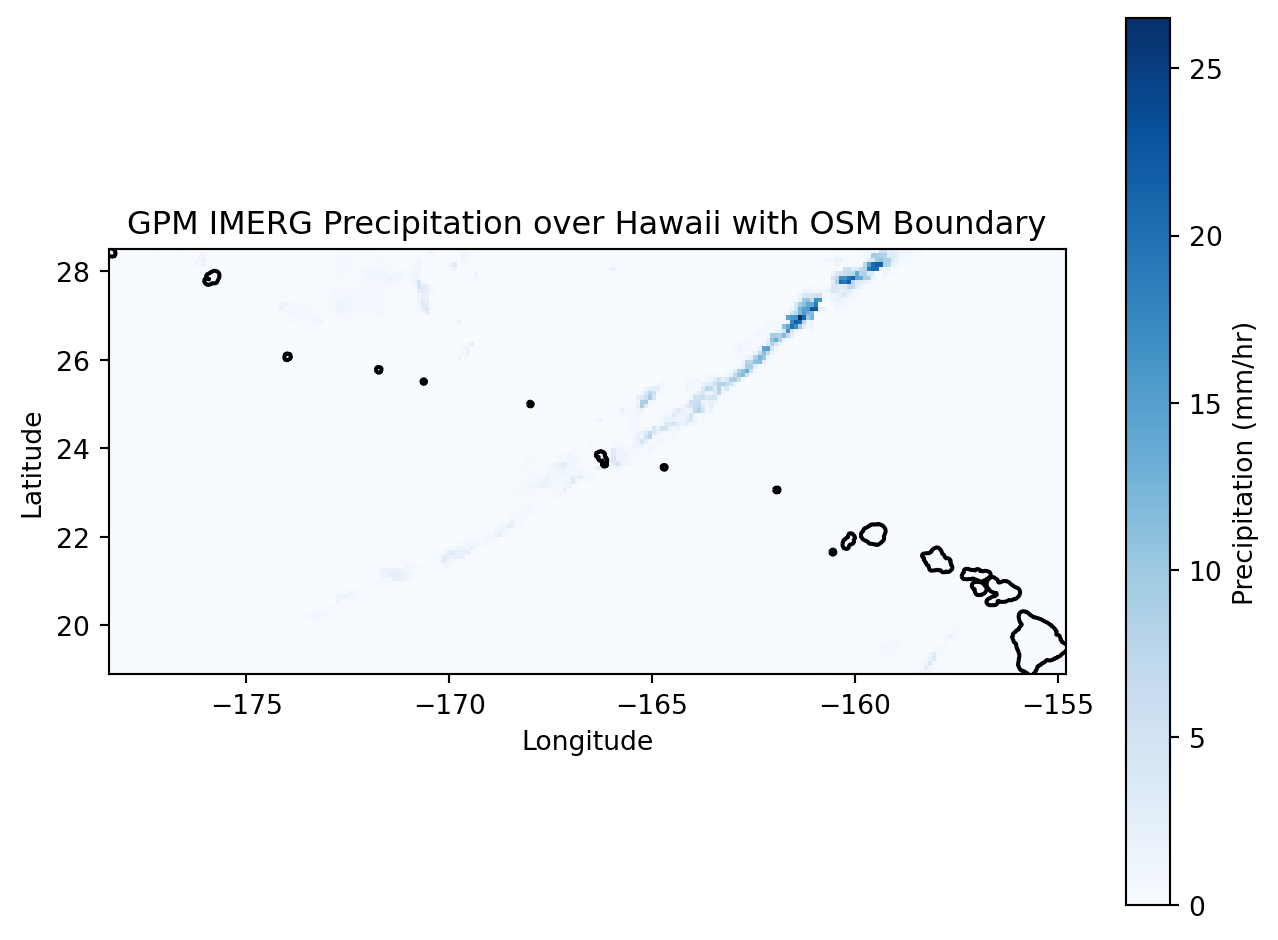

In [7]:
# Display the number of observations (files) found
print(len(file_path), "observations found.")


for file in file_path:
# Open the selected GPM IMERG dataset (e.g., 16th file in list)
    with xr.open_dataset(file_path[15], engine="h5netcdf", group="Grid") as ds:

        # Subset the precipitation variable to the Hawaii bounding box
        precip_subset = ds["precipitation"].sel(
            lat=slice(bounding_box[1], bounding_box[3]),
            lon=slice(bounding_box[0], bounding_box[2])
        )

        # Select the first time step and reorient data for plotting
        ras_data = precip_subset.isel(time=0)
        ras_data = ras_data.transpose("lat", "lon")

# Create a figure and axis
fig, ax = plt.subplots( )

# Plot the precipitation data
ras_data.plot(ax=ax, cmap="Blues", cbar_kwargs={"label": "Precipitation (mm/hr)"})

# Overlay the Hawaii boundary geometry from OSM
hawaii.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

# Add plot labels and formatting
plt.title("GPM IMERG Precipitation over Hawaii with OSM Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


## Animation: Visualizing Half-Hourly Rainfall Over Time

To understand how precipitation evolves over time, we can animate the sequence of GPM IMERG half-hourly rainfall images. This animation cycles through each file, extracts the timestamp, overlays the precipitation data on the Hawaii boundary, and renders a smooth temporal visualization using `matplotlib.animation`. This is especially helpful for spotting storm patterns and tracking rainfall intensity across the region.


In [8]:
#| eval: false



# Compute global min/max across all rasters
global_min = np.inf
global_max = -np.inf

for file in file_path:
    with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
        precip = ds["precipitation"].sel(
            lat=slice(bounding_box[1], bounding_box[3]),
            lon=slice(bounding_box[0], bounding_box[2])
        ).isel(time=0).transpose("lat", "lon")

        current_min = precip.min().item()
        current_max = precip.max().item()

        if np.isfinite(current_min):
            global_min = min(global_min, current_min)
        if np.isfinite(current_max):
            global_max = max(global_max, current_max)

# --- Start Plotting ---
fig, ax = plt.subplots( )  # Moved this up

# Load first frame just for layout
with xr.open_dataset(file_path[0], engine="h5netcdf", group="Grid") as ds:
    data0 = ds["precipitation"].sel(
        lat=slice(bounding_box[1], bounding_box[3]),
        lon=slice(bounding_box[0], bounding_box[2])
    ).isel(time=0).transpose("lat", "lon")

    lon = data0.lon.values
    lat = data0.lat.values

lon2d, lat2d = np.meshgrid(lon, lat)

# Plot the first frame using global vmin/vmax
mesh = ax.pcolormesh(
    lon2d, lat2d, data0.values,
    cmap="Blues", shading="auto",
    vmin=global_min, vmax=global_max
)

# Add a consistent colorbar
cbar = fig.colorbar(mesh, ax=ax, label="Precipitation (mm/hr)")

# Overlay the Hawaii boundary outline
hawaii.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, zorder=2)

# Set up the title and axes
title_text = ax.set_title(f"GPM IMERG Precipitation over Hawaii - Frame 1/{len(file_path)}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()

# --- Define update function for animation ---

def update(frame_index):
    file = file_path[frame_index]

    with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
        data = ds["precipitation"].sel(
            lat=slice(bounding_box[1], bounding_box[3]),
            lon=slice(bounding_box[0], bounding_box[2])
        ).isel(time=0).transpose("lat", "lon")

    # Parse timestamp
    filename = os.path.basename(file)
    match = re.search(r"3IMERG\.(\d{8})", filename)
    date_str = match.group(1)
    match = re.search(r"(\d{4}).V07B", filename)
    time_str = match.group(1)
    time_str = int(time_str)

    try:
        dt = datetime.strptime(date_str, "%Y%m%d") + timedelta(minutes=time_str)
        dt -= timedelta(hours=10)
        timestamp_str = dt.strftime("%Y-%m-%d %H:%M:%S HST")
    except ValueError:
        timestamp_str = f"Invalid time in filename: {time_str}"

    # Update the mesh
    mesh.set_array(data.values.ravel())
    title_text.set_text(f"GPM IMERG Precipitation over Hawaii — {timestamp_str}")
    return mesh, title_text

# --- Animate and Save ---

print("Creating animation...")

ani = animation.FuncAnimation(
    fig, update, frames=len(file_path),
    interval=200, blit=True, repeat=False
)

ani.save("data/images/hawaii_precip.gif", writer="pillow", fps=3)


![Hawaii GIF](data/images/hawaii_precip.gif)

 
#### Focusing on Maui

To focus analysis on our location of analysis, we use `osmnx` to retrieve the geographic boundary for Maui County, Hawaii from **OpenStreetMap**. We then extract its bounding box and apply a small buffer (0.1 degrees) to ensure that nearby data just outside the strict boundary is included. This padded extent will be used to spatially filter satellite precipitation data or other geospatial layers relevant to the region.


In [9]:
# Get the geometry for Maui County, Hawaii from OpenStreetMap
maui = ox.geocode_to_gdf("Maui County, Hawaii, USA").to_crs("EPSG:4326")

# Extract the bounding box of Maui County as (minx, miny, maxx, maxy)
bounding_box = maui.total_bounds

# Define a small padding buffer (in degrees) around the bounding box
pad = 0.1  # ~0.1 degrees ≈ 5–6 km buffer

# Compute padded latitude and longitude boundaries
lat_min = bounding_box[1] - pad  # Southern boundary
lat_max = bounding_box[3] + pad  # Northern boundary
lon_min = bounding_box[0] - pad  # Western boundary
lon_max = bounding_box[2] + pad  # Eastern boundary


After defining the padded bounding box for Maui, we can visualize GPM IMERG half-hourly precipitation data for that area. This plot overlays satellite-derived rainfall intensity on the island’s geographic outline using `xarray` and `matplotlib`, providing spatial context for localized precipitation events.


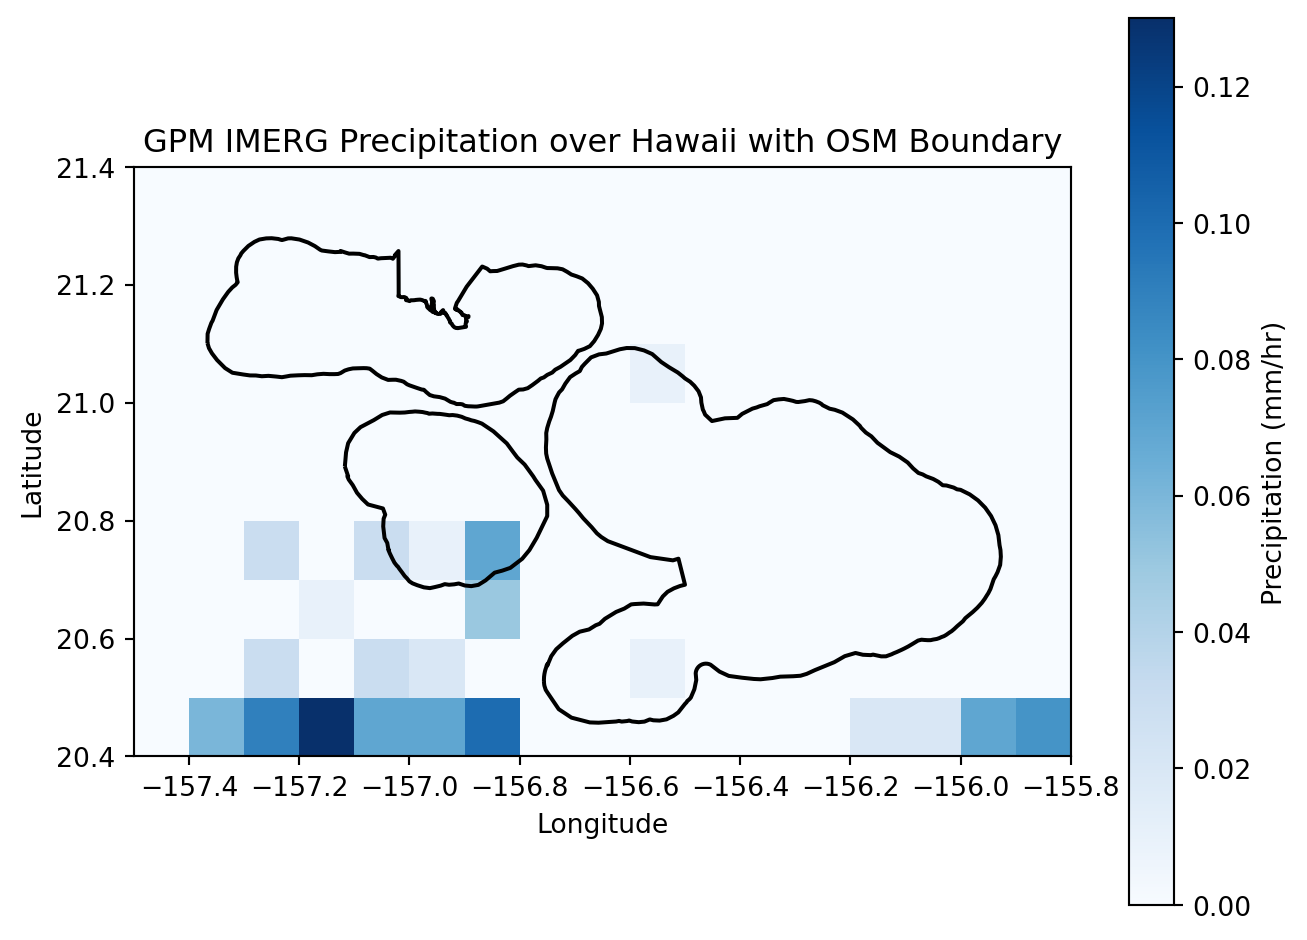

In [10]:
# Initialize figure and axis for the plot
fig, ax = plt.subplots()

with xr.open_dataset(file_path[15], engine="h5netcdf", group="Grid") as ds:

    # Subset the precipitation variable to the Hawaii bounding box
    precip_subset = ds["precipitation"].sel(
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max)
    )

    # Select the first time step and reorient data for plotting
    ras_data = precip_subset.isel(time=0)
    ras_data = ras_data.transpose("lat", "lon")


# Plot the precipitation data on the map
ras_data.plot(ax=ax, cmap="Blues", cbar_kwargs={"label": "Precipitation (mm/hr)"})

# Overlay the Maui County boundary using OSM data
maui.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

# Add plot title and axis labels
plt.title("GPM IMERG Precipitation over Hawaii with OSM Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


To visualize how rainfall evolves across Maui County, this animation cycles through a sequence of GPM IMERG half-hourly datasets. For each frame, it subsets the data to the Maui region, overlays the county boundary, and updates the timestamp extracted from the filename. The animation is then saved as a `.gif` for easy sharing and visual analysis.


In [11]:
#| eval: false



# Compute global min/max across all rasters
global_min = np.inf
global_max = -np.inf

for file in file_path:
    with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
        precip = ds["precipitation"].sel(
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max)
        ).isel(time=0).transpose("lat", "lon")

        current_min = precip.min().item()
        current_max = precip.max().item()

        if np.isfinite(current_min):
            global_min = min(global_min, current_min)
        if np.isfinite(current_max):
            global_max = max(global_max, current_max)

# --- Start Plotting ---
fig, ax = plt.subplots( )  # Moved this up

# Load first frame just for layout
with xr.open_dataset(file_path[0], engine="h5netcdf", group="Grid") as ds:
    data0 = ds["precipitation"].sel(
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max)
    ).isel(time=0).transpose("lat", "lon")

    lon = data0.lon.values
    lat = data0.lat.values

lon2d, lat2d = np.meshgrid(lon, lat)

norm = LogNorm(vmin=max(global_min, 0.01), vmax=global_max)

mesh = ax.pcolormesh(
    lon2d, lat2d, data0.values,
    cmap="Blues", shading="auto",
    norm=norm
)

# Add a consistent colorbar
cbar = fig.colorbar(mesh, ax=ax, label="Precipitation (mm/hr)")

# Overlay the Hawaii boundary outline
maui.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, zorder=2)

# Set up the title and axes
title_text = ax.set_title(f"GPM IMERG Precipitation over Hawaii - Frame 1/{len(file_path)}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()

# --- Define update function for animation ---

def update(frame_index):
    file = file_path[frame_index]

    with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
        data = ds["precipitation"].sel(
            lat=slice(lat_min, lat_max),
            lon=slice(lon_min, lon_max)
        ).isel(time=0).transpose("lat", "lon")

    # Parse timestamp
    filename = os.path.basename(file)
    match = re.search(r"3IMERG\.(\d{8})", filename)
    date_str = match.group(1)
    match = re.search(r"(\d{4}).V07B", filename)
    time_str = match.group(1)
    time_str = int(time_str)

    try:
        dt = datetime.strptime(date_str, "%Y%m%d") + timedelta(minutes=time_str)
        dt -= timedelta(hours=10)
        timestamp_str = dt.strftime("%Y-%m-%d %H:%M:%S HST")
    except ValueError:
        timestamp_str = f"Invalid time in filename: {time_str}"

    # Update the mesh
    mesh.set_array(data.values.ravel())
    title_text.set_text(f"GPM IMERG Precipitation over Maui, Hawaii — {timestamp_str}")
    return mesh, title_text

# --- Animate and Save ---

print("Creating animation...")

ani = animation.FuncAnimation(
    fig, update, frames=len(file_path),
    interval=200, blit=True, repeat=False
)
  

ani.save("data/images/maui_precip.gif", writer="pillow", fps=3)  # Save to file at 3 frames per second

![Maui GIF](data/images/maui_precip.gif)


### Extracting Time Series of Mean Precipitation Over Maui


We can use the GPM IMERG half-hourly precipitation files to calculates the mean rainfall over Maui County for each timestep. The data is spatially subset to the OSM Maui bounding box, rasterized using a *geographic transform*, and then aggregated over the island polygon using the function `zonal_stats`. Results are compiled into a *DataFrame* for further analysis or plotting.


In [12]:
# Prepare an empty list to store the results for each file
results = []

# Loop through each file in the downloaded GPM IMERG dataset
for file in file_path:
    try:
        # --- Open and subset precipitation data ---
        with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
            # Select and subset precipitation for Maui bounding box
            data = ds["precipitation"].sel(
                lat=slice(lat_min, lat_max),     # Latitude bounds
                lon=slice(lon_min, lon_max)      # Longitude bounds
            ).isel(time=0).transpose("lat", "lon")  # First timestep and axis order for raster analysis

        # --- Build affine transform for georeferencing raster ---
        lats = data["lat"].values              # Latitude array
        lons = data["lon"].values              # Longitude array
        res_x = lons[1] - lons[0]              # Pixel width
        res_y = lats[1] - lats[0]              # Pixel height (note: no flip needed if ordered from top to bottom)
        transform = from_origin(
            west=lons.min(),                   # Western edge
            north=lats.max(),                  # Northern edge
            xsize=res_x,                       # Horizontal resolution
            ysize=res_y                        # Vertical resolution
        )

        # --- Extract raw array of precipitation values ---
        arr = data.values                      # 2D array (lat × lon)

        # --- Parse datetime from filename ---
        filename = os.path.basename(file)      # Extract base filename
        match_date = re.search(r"3IMERG\.(\d{8})", filename)   # Extract date string (YYYYMMDD)
        match_min = re.search(r"\.(\d{4,5})\.V", filename)     # Extract time in minutes

        if match_date and match_min:
            date_str = match_date.group(1)
            mins_str = match_min.group(1)
            dt = datetime.strptime(date_str, "%Y%m%d") + timedelta(minutes=int(mins_str))  # Combine date and time
            dt = dt - timedelta(hours=10)      # Convert from UTC to Hawaii Standard Time
        else:
            dt = None                          # Fallback if parsing fails

        # --- Compute zonal mean over the Maui polygon ---
        stats = zonal_stats(
            maui,                              # Polygon geometry
            arr,                               # Raster array
            affine=transform,                  # Spatial transform
            stats="mean",                      # Compute mean value
            nodata=np.nan                      # Handle missing values
        )[0]

        # Extract mean precipitation value from the stats result
        mean_precip = stats["mean"]

        # Append timestamp and mean to results list
        results.append({
            "datetime": dt,
            "mean_precip": mean_precip
        })

    except Exception as e:
        # Catch and report any errors (e.g., malformed file or data)
        print(f"Skipping file {file} due to error: {e}")

# --- Convert results list to a clean DataFrame ---
results_df = pd.DataFrame(results)  # Each row: [datetime, mean_precip]

Now that we’ve extracted mean precipitation values for each GPM IMERG file, we can visualize how rainfall changes over time across Maui County. This line plot presents a temporal snapshot of precipitation intensity, helping to identify storm events, rainfall variability, and dry periods.


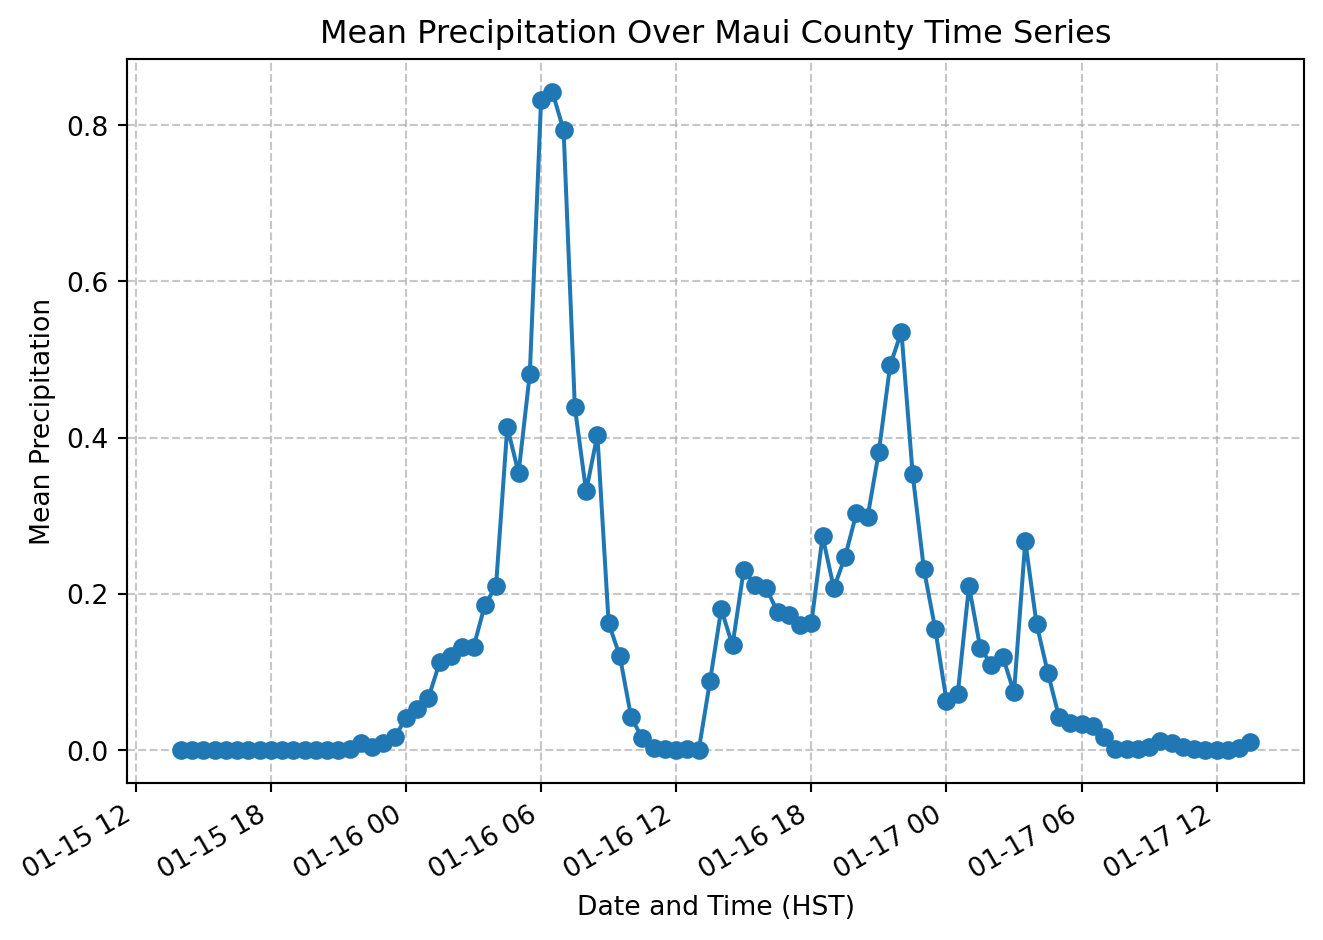

In [13]:
# Create the time series line plot
plt.figure( )  # Set figure size for clarity and legibility

# Plot datetime vs. mean precipitation with markers and connecting lines
plt.plot(results_df['datetime'], results_df['mean_precip'], marker='o', linestyle='-')

# Add a title and axis labels to describe the plot
plt.title('Mean Precipitation Over Maui County Time Series')     # Plot title
plt.xlabel('Date and Time (HST)')                                 # X-axis label
plt.ylabel('Mean Precipitation')                                  # Y-axis label (units assumed mm/hr)

# Automatically format x-axis to prevent overlapping date labels
plt.gcf().autofmt_xdate()  # Rotate and align date labels on the x-axis

# Add a dashed grid to the background for easier reading
plt.grid(True, linestyle='--', alpha=0.7)  # Enable grid with light dashed lines

# Adjust spacing to prevent overlapping elements
plt.tight_layout()

# Display the plot in the output cell
plt.show()

## Comparing IMERG Sattelite data and Oberved Precipitation data

The data for this report comes from the Kahului Airport and downloaded from [WeatherSpark](https://weatherspark.com/h/d/150359/2024/1/16/Historical-Weather-on-Tuesday-January-16-2024-in-Maui-Hawaii-United-States#metar-00-14).


In [14]:
# Load your CSV (update with your actual file path)
obs_df = pd.read_csv("data/maui_rain/maui_rain_gauge_Jan2024.csv")
 

# Parse datetime
obs_df["datetime"] = pd.to_datetime(obs_df["Date"] + " " + obs_df["Time"])

# Convert precipitation to float
obs_df["obs_precip"] = obs_df["Precipitation"].str.replace(" in", "", regex=False).astype(float)


C:\Users\jmartine\AppData\Local\Temp\8\ipykernel_25852\3286023823.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  obs_df["datetime"] = pd.to_datetime(obs_df["Date"] + " " + obs_df["Time"])


Plot the data with dual y-axis without proportional scaling to visually compare the two datasets.


C:\Users\jmartine\AppData\Local\Temp\8\ipykernel_25852\2757781746.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  obs_df["datetime"] = pd.to_datetime(obs_df["Date"] + " " + obs_df["Time"])


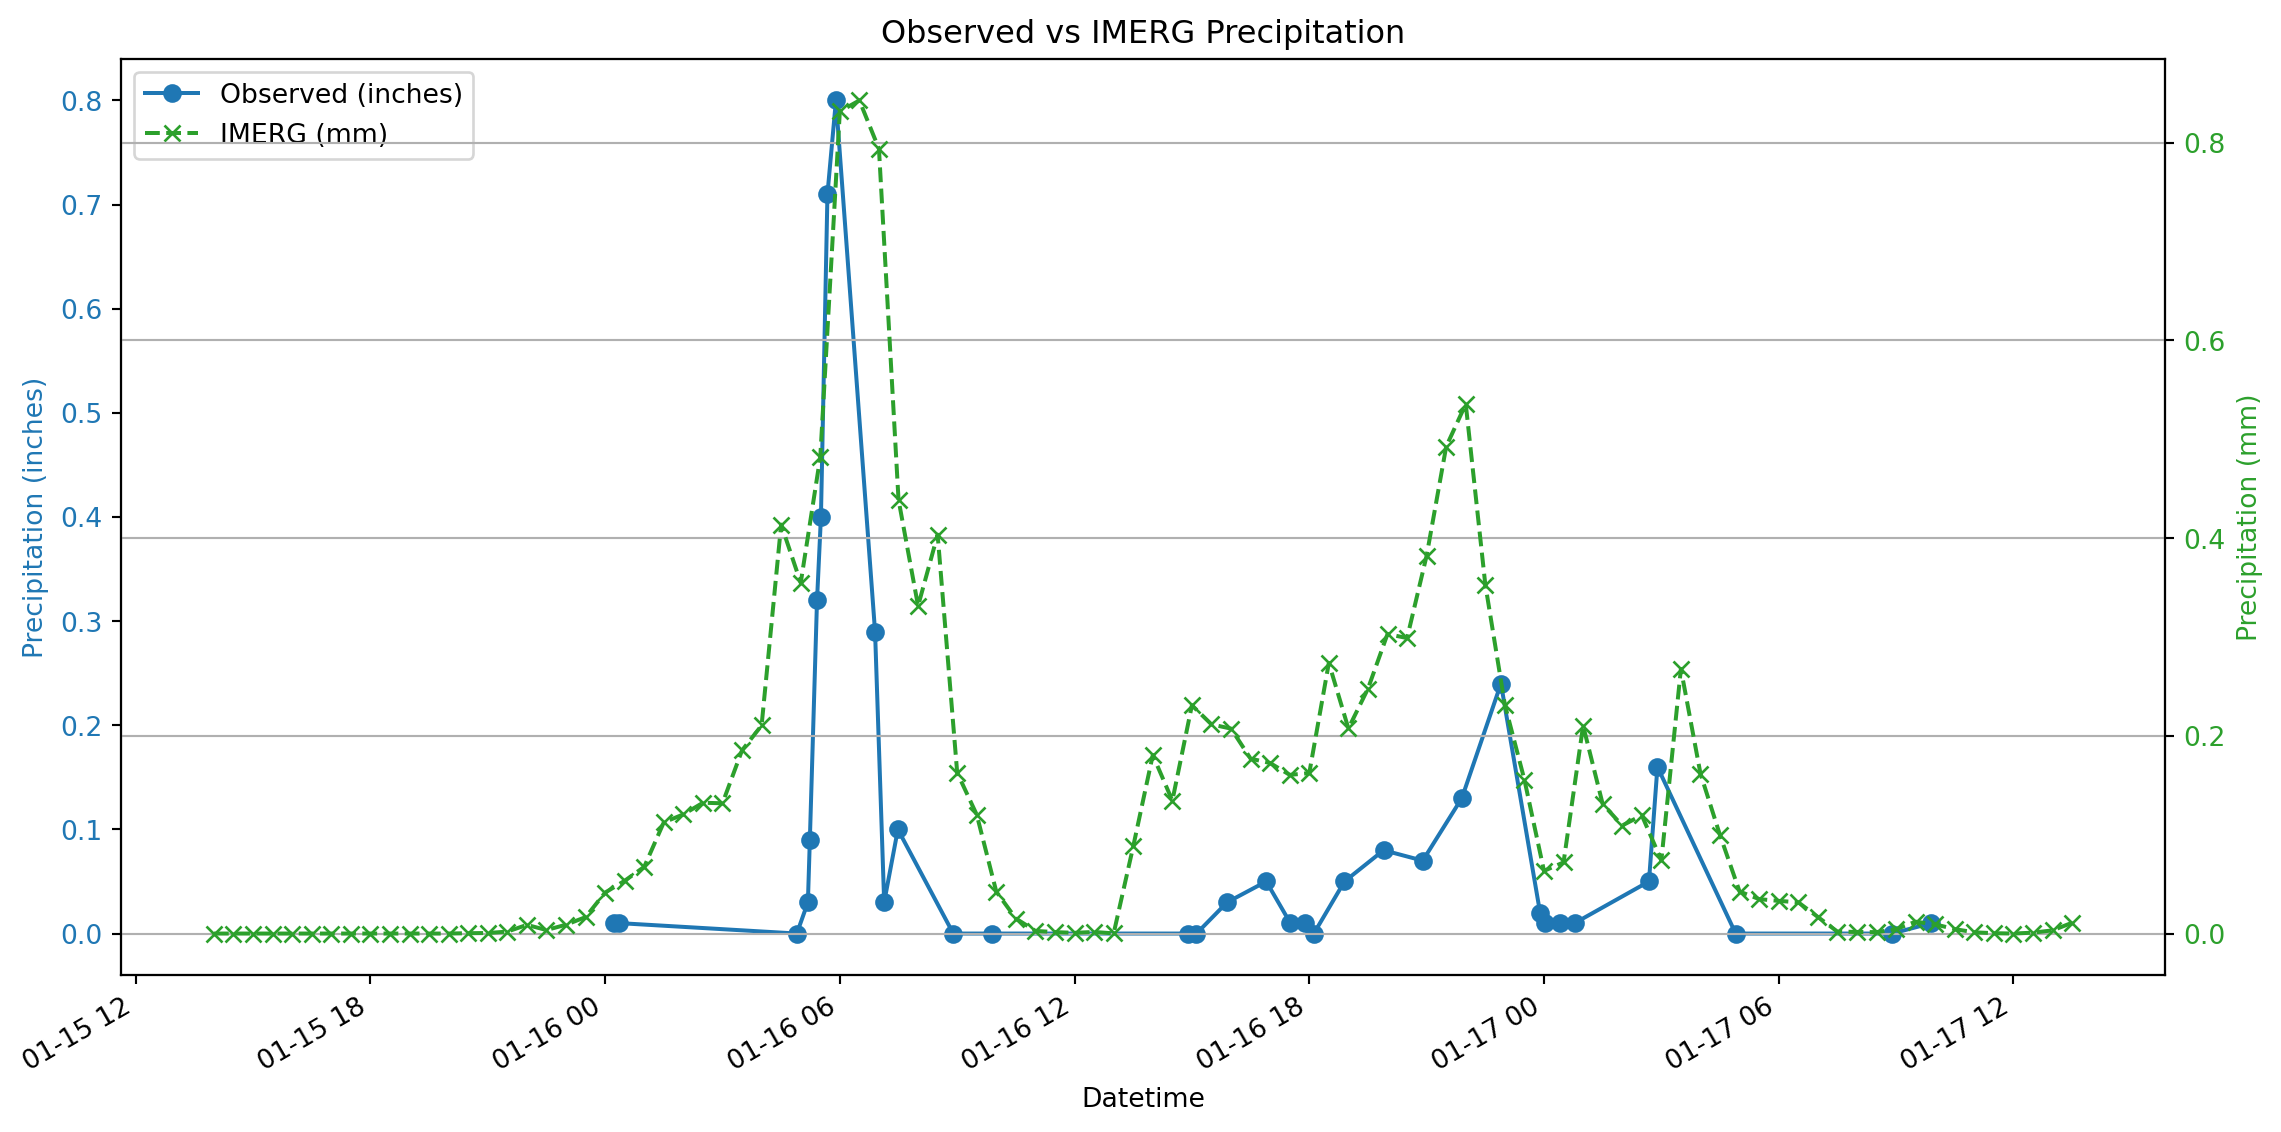

In [15]:
# Make sure datetime columns are parsed
obs_df["datetime"] = pd.to_datetime(obs_df["Date"] + " " + obs_df["Time"])
obs_df["obs_precip"] = obs_df["Precipitation"].str.replace(" in", "", regex=False).astype(float)

results_df["datetime"] = pd.to_datetime(results_df["datetime"])

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot observed precipitation on left y-axis
line1, = ax1.plot(
    obs_df["datetime"], obs_df["obs_precip"],
    label="Observed (inches)", color="tab:blue", marker="o"
)
ax1.set_ylabel("Precipitation (inches)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Create right y-axis
ax2 = ax1.twinx()

# Plot IMERG precipitation on right y-axis (assumed in mm)
line2, = ax2.plot(
    results_df["datetime"], results_df["mean_precip"],
    label="IMERG (mm)", color="tab:green", marker="x", linestyle="--"
)
ax2.set_ylabel("Precipitation (mm)", color="tab:green")
ax2.tick_params(axis='y', labelcolor="tab:green")

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

# Formatting
plt.title("Observed vs IMERG Precipitation")
ax1.set_xlabel("Datetime")
fig.autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()


## Integrating Maui Census Tract Data

This section downloads the latest census tract shapefile for Hawaii and loads it as a GeoDataFrame.


In [16]:
shapefile_zip = "data/maui_rain/tl_2023_15_tract.zip"
shapefile_dir = "data/maui_rain/tl_2023_15_tract"

In [17]:
#| eval: false

# Set URLs and file paths
tiger_url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_15_tract.zip"



# Ensure the directory exists
os.makedirs(os.path.dirname(shapefile_zip), exist_ok=True)

# Download and extract if not already present
if not os.path.exists(shapefile_dir):
    r = requests.get(tiger_url, verify=False)
    with open(shapefile_zip, 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile(shapefile_zip, 'r') as zip_ref:
        zip_ref.extractall(shapefile_dir)

In [18]:
# Load shapefile
tracts = gpd.read_file(os.path.join(shapefile_dir, 'tl_2023_15_tract.shp'))

## Fetch ACS 2023 Population Data for Maui Tracts

This section retrieves the latest census population data for Maui tracts and merges it with the shapefile.


In [19]:
#| eval: false


# Provide your Census API key
API_KEY = "API_KEY"
acs_url = (
    "https://api.census.gov/data/2023/acs/acs5"
    "?get=NAME,B01003_001E&for=tract:*&in=state:15+county:009"
    f"&key={API_KEY}"
)

response = requests.get(acs_url)

In [20]:
#| echo: false



# Provide your Census API key
API_KEY = "4c4fb31afba1ae4fbf35b9f8a0d0d65e0432f6e9"
acs_url = (
    "https://api.census.gov/data/2023/acs/acs5"
    "?get=NAME,B01003_001E&for=tract:*&in=state:15+county:009"
    f"&key={API_KEY}"
)

response = requests.get(acs_url)

## Combining Census data with TIGER shapes

In [21]:
census_data = response.json()
census_df = pd.DataFrame(census_data[1:], columns=census_data[0])
census_df['GEOID'] = census_df['state'] + census_df['county'] + census_df['tract']

# Merge population data with tracts
tracts = tracts.merge(
    census_df[['GEOID', 'B01003_001E']],
    on='GEOID',
    how='left'
)
tracts['B01003_001E'] = pd.to_numeric(tracts['B01003_001E'])

In [22]:
#| eval: false

global_min, global_max = np.inf, -np.inf
for file in file_path:
    with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
        precip = ds["precipitation"].sel(
            lat=slice(lat_min, lat_max),
            lon=slice(lon_min, lon_max)
        ).isel(time=0).transpose("lat", "lon")
        current_min = precip.min().item()
        current_max = precip.max().item()
        if np.isfinite(current_min): global_min = min(global_min, current_min)
        if np.isfinite(current_max): global_max = max(global_max, current_max)

# Optional: Use a LogNorm to enhance contrast
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=0.05, vmax=global_max)

fig, ax = plt.subplots( )

# Load first raster
with xr.open_dataset(file_path[0], engine="h5netcdf", group="Grid") as ds:
    data0 = ds["precipitation"].sel(
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max)
    ).isel(time=0).transpose("lat", "lon")
    lon = ds["lon"].sel(lon=slice(lon_min, lon_max)).values
    lat = ds["lat"].sel(lat=slice(lat_min, lat_max)).values

lon2d, lat2d = np.meshgrid(lon, lat)

# Plot base precipitation frame
mesh = ax.pcolormesh(
    lon2d, lat2d, data0.values,
    cmap="Blues", shading="auto", norm=norm, zorder=1
)
cbar = fig.colorbar(mesh, ax=ax, label="Precipitation (mm/hr)")

# Plot census tracts colored by population
tracts.plot(
    ax=ax,
    column='B01003_001E',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.6,
    zorder=2,
    legend=True,
    legend_kwds={'label': "Population (ACS B01003_001E)"}
)

# Title and axes
title_text = ax.set_title("Frame 1")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()

# -----------------------------
# Step 4: Define Animation
# -----------------------------
def update(frame_index):
    file = file_path[frame_index]
    with xr.open_dataset(file, engine="h5netcdf", group="Grid") as ds:
        data = ds["precipitation"].sel(
            lat=slice(lat_min, lat_max),
            lon=slice(lon_min, lon_max)
        ).isel(time=0).transpose("lat", "lon")
    
    # Update raster data
    data_vals = data.values
    data_vals[data_vals <= 0] = np.nan  # Avoid log(0)
    mesh.set_array(data_vals.ravel())

    # Timestamp label
    filename = os.path.basename(file)
    date_match = re.search(r"3IMERG\.(\d{8})", filename)
    time_match = re.search(r"(\d{4}).V07B", filename)
    if date_match and time_match:
        date_str = date_match.group(1)
        minutes = int(time_match.group(1))
        dt = datetime.strptime(date_str, "%Y%m%d") + timedelta(minutes=minutes) - timedelta(hours=10)
        label = dt.strftime("%Y-%m-%d %H:%M:%S HST")
    else:
        label = "Unknown timestamp"

    title_text.set_text(f"Maui 2023 Population & Precipitation — {label}")
    return mesh, title_text

# -----------------------------
# Step 5: Run and Save Animation
# -----------------------------
ani = animation.FuncAnimation(
    fig, update, frames=len(file_path),
    interval=200, blit=True, repeat=False
)

ani.save("data/images/maui_precip_population.gif", writer="pillow", fps=3)

![Maui Rain Population GIF](data/images/maui_precip_population.gif)




 
   

## Summary

This workflow demonstrates how to:

- Download and merge census tract boundaries and population data for Maui.
- Process and map local rainfall station observations.
- Overlay demographic and environmental data for actionable disaster analysis.

You can expand this analysis by incorporating additional census variables, different time periods, or more advanced spatial statistics as needed for your project.